<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-modules" data-toc-modified-id="Import-modules-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import modules</a></span></li><li><span><a href="#RequestFunc" data-toc-modified-id="RequestFunc-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>RequestFunc</a></span></li><li><span><a href="#Plot-Table" data-toc-modified-id="Plot-Table-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot Table</a></span></li><li><span><a href="#Main" data-toc-modified-id="Main-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Main</a></span></li></ul></div>

# Import modules 

In [22]:
import requests
import pandas as pd
from copy import deepcopy
from datetime import datetime, timedelta
from time import sleep
import os

parent = os.path.dirname(os.path.abspath("__file__"))
output_path = os.path.join(parent, 'Opt_OI')
if not os.path.isdir(output_path):
    os.makedirs(output_path)

# RequestFunc

In [209]:
def GetOptionOI(ticker="QQQ"):
    
    #=====================
    # Read Update Data
    #=====================
    try:
        url = f"https://cdn.cboe.com/api/global/delayed_quotes/options/{ticker.upper()}.json"
        res = requests.get(url)
        data = res.json()
    except:
        url = f"https://cdn.cboe.com/api/global/delayed_quotes/options/_{ticker.upper()}.json"
        res = requests.get(url)
        data = res.json()
    opts_ = data['data']['options']

    #=====================
    # Setup Output Path
    #=====================
    trade_date = pd.to_datetime(data['data']['last_trade_time']) # datetime.today()
    print(f"====== {trade_date} ======")
    output_ = os.path.join(output_path, str(trade_date.year), str(trade_date.month).zfill(2), str(trade_date.day).zfill(2))
    if not os.path.isdir(output_):
        os.makedirs(output_)
    #------------------------
    # Take Update Option Info
    #------------------------
    updated_datas = []
    for opt in opts_:
        opt_symbol = opt['option']
        underlying = opt_symbol[:-15]
        strike = int(opt_symbol[-8:]) / 1000
        c_p = opt_symbol[-9:-8]
        ttm = opt_symbol[-15:-9]
#         print(underlying, ttm, c_p, strike)
        opt.update({
            'underlying':underlying,
            'ttm':ttm,
            'strike':strike,
            'c_p':c_p
        })
        updated_datas.append(opt)

    #========================
    # Aggregate wit DataFrame
    #========================
    opt_df = pd.DataFrame(updated_datas)
    outputRawOI(opt_df, output_, ticker)
    nearby_df = opt_df[opt_df['ttm'].apply(lambda x: x[:4]) == opt_df['ttm'].apply(lambda x: x[:4]).unique()[0]]

    #------------------------
    # Seperate Call and Put
    #------------------------
#     filted_ttm_g = {"C":[], "P":[]}
#     ttm_group = nearby_df.groupby('ttm')
#     for ttm in ttm_group.groups:
#         print(ttm)
#         ttm_g = ttm_group.get_group(ttm)
#         ttm_g = ttm_g['option,underlying,strike,ttm,c_p,open_interest'.split(',')]
#         for C_P in ttm_g.c_p.unique():
#             filted_ttm_g[C_P].append(ttm_g[ttm_g.c_p == C_P].set_index('strike'))

#     #-------------------------
#     # Create dataframe of call
#     #-------------------------
#     call_df = pd.DataFrame()
#     call_df.index.name = 'strike'
#     for c_df in filted_ttm_g["C"]:
#         if call_df.empty:
#             call_df = c_df
#         else:
#             for row in c_df.itertuples():
#                 try:
#                     call_df.loc[row.Index, 'open_interest'] += row.open_interest
#                 except:
#                     tmp_row = dict(row._asdict())
#                     tmp_row['strike'] = tmp_row['Index']
#                     del tmp_row['Index']
#                     call_df = call_df.append(pd.DataFrame([tmp_row]).set_index('strike'))
                    
#     #-------------------------
#     # Create dataframe of put
#     #-------------------------
#     put_df = pd.DataFrame()
#     put_df.index.name = 'strike'
#     for p_df in filted_ttm_g["P"]:
#         if put_df.empty:
#             put_df = p_df
#         else:
#             for row in p_df.itertuples():
#                 try:
#                     put_df.loc[row.Index, 'open_interest'] += row.open_interest
#                 except:
#                     tmp_row = dict(row._asdict())
#                     tmp_row['strike'] = tmp_row['Index']
#                     del tmp_row['Index']
#                     put_df = put_df.append(pd.DataFrame([tmp_row]).set_index('strike'))
    
#     #========================
#     # Save Today Info
#     #========================
#     tmp_call_df = call_df.sort_values('open_interest', ascending=False).reset_index()['strike,open_interest'.split(',')]
#     tmp_call_df['oi_diff'] = 0

#     tmp_put_df = put_df.sort_values('open_interest', ascending=False).reset_index()['strike,open_interest'.split(',')]
#     tmp_put_df['oi_diff'] = 0

    
#     with pd.ExcelWriter(os.path.join(output_, f"{ticker}_Option_OI.xlsx")) as writer:
#         tmp_call_df.to_excel(writer, encoding='utf-8-sig', index=False, sheet_name="CALL")
#         tmp_put_df.to_excel(writer, encoding='utf-8-sig', index=False, sheet_name="PUT")
        
    sleep(3)

In [195]:
def outputRawOI(opt_df, output_, ticker):
    with pd.ExcelWriter(os.path.join(output_, f"{ticker}_Option_OI_raw.xlsx")) as writer:
        ttms = sorted(opt_df.ttm.unique())
        for ttm in ttms:
            ttm_df = opt_df[opt_df.ttm == ttm]
            tmp_df_c = ttm_df[ttm_df.c_p == "C"]
            tmp_df_p = ttm_df[ttm_df.c_p == "P"]
    
            tmp_df_c.to_excel(writer, encoding='utf-8-sig', index=False, sheet_name=ttm)
            tmp_df_p.to_excel(writer, encoding='utf-8-sig', index=False, sheet_name=ttm, startcol = 29)
            
def GetLastTwoPath(ticker='QQQ', td=datetime.today()):
    i = -1
    update_f_path = None
    last_f_path = None
    last_date = update_date = None
    print(td)
    while 1:
        last_day = td + timedelta(i)
        
        print(last_day)
        i-=1
        output_ = os.path.join(output_path, str(last_day.year), str(last_day.month).zfill(2), str(last_day.day).zfill(2))
        f_path = os.path.join(output_, f"{ticker}_Option_OI_raw.xlsx")
        if not update_f_path:
            if os.path.isfile(f_path):
                update_f_path = f_path
                update_date = last_day
        elif not last_f_path:
            if os.path.isfile(f_path):
                last_f_path = f_path
                last_date = last_day
        if update_f_path and last_f_path:
            break
    
    return last_f_path, last_date, update_f_path, update_date

# def ReadRawOI(ticker='QQQ'):
#     last_f_path, update_f_path = GetLastTwoPath(ticker)
#     xl_last = pd.ExcelFile(last_f_path)
#     xl_update = pd.ExcelFile(update_f_path)

In [211]:
last_f_path, last_date, update_f_path, update_date = GetLastTwoPath("QQQ")
xl_last = pd.read_excel(last_f_path, None, engine='openpyxl')
xl_update = pd.read_excel(update_f_path, None, engine='openpyxl')

2022-07-28 15:33:11.108590
2022-07-27 15:33:11.108590
2022-07-26 15:33:11.108590


In [212]:
last_date, update_date

(datetime.datetime(2022, 7, 26, 15, 33, 11, 108590),
 datetime.datetime(2022, 7, 27, 15, 33, 11, 108590))

In [213]:
last_ttms = sorted(set([x[:4] for x in xl_last.keys()]))
update_ttms = sorted(set([x[:4] for x in xl_update.keys()]))

last_near_ttms = [x for x in xl_last.keys() if x[:4] == last_ttms[0]]
update_near_ttms = [x for x in xl_update.keys() if x[:4] == update_ttms[0]]

last_near2_ttms = [x for x in xl_last.keys() if x[:4] == last_ttms[1]]
update_near2_ttms = [x for x in xl_update.keys() if x[:4] == update_ttms[1]]

In [214]:
last_near_ttms, update_near_ttms

(['220727', '220729'], ['220727', '220729'])

In [215]:
last_near2_ttms, update_near2_ttms

(['220801',
  '220803',
  '220805',
  '220808',
  '220810',
  '220812',
  '220815',
  '220817',
  '220819',
  '220822',
  '220824',
  '220826',
  '220829',
  '220831'],
 ['220801',
  '220803',
  '220805',
  '220808',
  '220810',
  '220812',
  '220815',
  '220817',
  '220819',
  '220822',
  '220824',
  '220826',
  '220829',
  '220831'])

In [71]:
def AggregateDF(xl, ttms):

    # aggregate last
    call_df = pd.DataFrame()
    call_df.index.name = 'strike'

    put_df = pd.DataFrame()
    put_df.index.name = 'strike'
    for ttm in ttms:
        tmp_df = xl[ttm]
        tmp_call_df = tmp_df['open_interest,underlying,ttm,strike,c_p'.split(',')].set_index("strike")
        tmp_put_df = tmp_df['open_interest.1,underlying.1,ttm.1,strike.1,c_p.1'.split(',')]
        tmp_put_df.columns = 'open_interest,underlying,ttm,strike,c_p'.split(',')
        tmp_put_df = tmp_put_df.set_index('strike')

        if call_df.empty:
            call_df = tmp_call_df
        else:
            for row in tmp_call_df.itertuples():
                try:
                    call_df.loc[row.Index, 'open_interest'] += row.open_interest
                except:
                    tmp_row = dict(row._asdict())
                    tmp_row['strike'] = tmp_row['Index']
                    del tmp_row['Index']
                    call_df = call_df.append(pd.DataFrame([tmp_row]).set_index('strike'))

        if put_df.empty:
            put_df = tmp_put_df
        else:
            for row in tmp_put_df.itertuples():
                try:
                    put_df.loc[row.Index, 'open_interest'] += row.open_interest
                except:
                    tmp_row = dict(row._asdict())
                    tmp_row['strike'] = tmp_row['Index']
                    del tmp_row['Index']
                    put_df = put_df.append(pd.DataFrame([tmp_row]).set_index('strike'))

    call_df = call_df.sort_values("open_interest", ascending=False)
    put_df = put_df.sort_values("open_interest", ascending=False)
    
    print(call_df.head(10))
    print(put_df.head(10))
    print(call_df.open_interest.sum(), put_df.open_interest.sum())
    
    return call_df, put_df

In [216]:
last_call, last_put = AggregateDF(xl_last, last_near_ttms)

        open_interest underlying     ttm c_p
strike                                      
305.0           43956        QQQ  220727   C
300.0           39473        QQQ  220727   C
310.0           33555        QQQ  220727   C
315.0           28506        QQQ  220727   C
295.0           24567        QQQ  220727   C
290.0           24498        QQQ  220727   C
297.0           19471        QQQ  220727   C
302.0           14271        QQQ  220727   C
320.0           13931        QQQ  220727   C
307.0           13052        QQQ  220727   C
        open_interest underlying     ttm c_p
strike                                      
290.0           40214        QQQ  220727   P
285.0           39492        QQQ  220727   P
270.0           33386        QQQ  220727   P
280.0           27777        QQQ  220727   P
295.0           26406        QQQ  220727   P
255.0           24994        QQQ  220727   P
300.0           22286        QQQ  220727   P
275.0           21945        QQQ  220727   P
250.0     

In [217]:
update_call, update_put = AggregateDF(xl_update, update_near_ttms)

        open_interest underlying     ttm c_p
strike                                      
300.0           37422        QQQ  220727   C
305.0           35457        QQQ  220727   C
310.0           32091        QQQ  220727   C
315.0           27236        QQQ  220727   C
290.0           24123        QQQ  220727   C
295.0           23441        QQQ  220727   C
297.0           19487        QQQ  220727   C
320.0           14054        QQQ  220727   C
311.0           11182        QQQ  220727   C
302.0           11137        QQQ  220727   C
        open_interest underlying     ttm c_p
strike                                      
300.0           45099        QQQ  220727   P
285.0           40698        QQQ  220727   P
290.0           38037        QQQ  220727   P
295.0           37872        QQQ  220727   P
270.0           33541        QQQ  220727   P
280.0           27023        QQQ  220727   P
255.0           25009        QQQ  220727   P
250.0           20858        QQQ  220727   P
240.0     

In [218]:
update_call['diff'] = update_call['open_interest'] - last_call['open_interest']
update_put['diff'] = update_put['open_interest'] - last_put['open_interest']

In [219]:
update_call['diff'].sum(), update_put['diff'].sum()

(-9744, 88625)

In [220]:
update_call

,open_interest,underlying,ttm,c_p,diff
strike,,,,,
300.0,37422,QQQ,220727,C,-2051
305.0,35457,QQQ,220727,C,-8499
310.0,32091,QQQ,220727,C,-1464
315.0,27236,QQQ,220727,C,-1270
290.0,24123,QQQ,220727,C,-375
...,...,...,...,...,...
242.0,0,QQQ,220727,C,0
235.0,0,QQQ,220727,C,0
236.0,0,QQQ,220727,C,0


In [221]:
last_call2, last_put2 = AggregateDF(xl_last, last_near2_ttms)

        open_interest underlying     ttm c_p
strike                                      
300.0          121102        QQQ  220801   C
305.0          109198        QQQ  220801   C
310.0          101737        QQQ  220801   C
320.0           69482        QQQ  220801   C
315.0           61999        QQQ  220801   C
326.0           38777        QQQ  220801   C
295.0           38626        QQQ  220801   C
325.0           36384        QQQ  220801   C
290.0           34929        QQQ  220801   C
330.0           34759        QQQ  220801   C
        open_interest underlying     ttm c_p
strike                                      
280.0          139631        QQQ  220801   P
290.0          116055        QQQ  220801   P
285.0          110603        QQQ  220801   P
300.0           81984        QQQ  220801   P
270.0           76122        QQQ  220801   P
250.0           75032        QQQ  220801   P
260.0           70816        QQQ  220801   P
210.0           68382        QQQ  220801   P
305.0     

In [222]:
update_call2, update_put2 = AggregateDF(xl_update, update_near2_ttms)

        open_interest underlying     ttm c_p
strike                                      
300.0          113549        QQQ  220801   C
305.0          108079        QQQ  220801   C
310.0           97631        QQQ  220801   C
315.0           73373        QQQ  220801   C
320.0           55029        QQQ  220801   C
326.0           45606        QQQ  220801   C
295.0           38084        QQQ  220801   C
325.0           37290        QQQ  220801   C
330.0           35052        QQQ  220801   C
290.0           34768        QQQ  220801   C
        open_interest underlying     ttm c_p
strike                                      
280.0          162291        QQQ  220801   P
290.0          138317        QQQ  220801   P
285.0          120750        QQQ  220801   P
300.0           99299        QQQ  220801   P
270.0           87049        QQQ  220801   P
250.0           74938        QQQ  220801   P
260.0           70902        QQQ  220801   P
210.0           68469        QQQ  220801   P
305.0     

In [223]:
update_call2['diff'] = update_call2['open_interest'] - last_call2['open_interest']
update_put2['diff'] = update_put2['open_interest'] - last_put2['open_interest']

# Plot Table

In [94]:
import matplotlib as mpl


def mergecells(table, ix0, ix1):
    ix0,ix1 = np.asarray(ix0), np.asarray(ix1)
    d = ix1 - ix0
    if not (0 in d and 1 in np.abs(d)):
        raise ValueError("ix0 and ix1 should be the indices of adjacent cells. ix0: %s, ix1: %s" % (ix0, ix1))

    if d[0]==-1:
        edges = ('BRL', 'TRL')
    elif d[0]==1:
        edges = ('TRL', 'BRL')
    elif d[1]==-1:
        edges = ('BTR', 'BTL')
    else:
        edges = ('BTL', 'BTR')

    # hide the merged edges
    for ix,e in zip((ix0, ix1), edges):
        table[ix[0], ix[1]].visible_edges = e

    txts = [table[ix[0], ix[1]].get_text() for ix in (ix0, ix1)]
    tpos = [np.array(t.get_position()) for t in txts]

    # center the text of the 0th cell between the two merged cells
    trans = (tpos[1] - tpos[0])/2
    if trans[0] > 0 and txts[0].get_ha() == 'right':
        # reduce the transform distance in order to center the text
        trans[0] /= 2
    elif trans[0] < 0 and txts[0].get_ha() == 'right':
        # increase the transform distance...
        trans[0] *= 2

    txts[0].set_transform(mpl.transforms.Affine2D().translate(*trans))

    # hide the text in the 1st cell
    txts[1].set_visible(False)

In [199]:
def mergecells2(table, cells):
    '''
    Merge N matplotlib.Table cells

    Parameters
    -----------
    table: matplotlib.Table
        the table
    cells: list[set]
        list of sets od the table coordinates
        - example: [(0,1), (0,0), (0,2)]

    Notes
    ------
    https://stackoverflow.com/a/53819765/12684122
    '''
    cells_array = [np.asarray(c) for c in cells]
    h = np.array([cells_array[i+1][0] - cells_array[i][0] for i in range(len(cells_array) - 1)])
    v = np.array([cells_array[i+1][1] - cells_array[i][1] for i in range(len(cells_array) - 1)])

    # if it's a horizontal merge, all values for `h` are 0
    if not np.any(h):
        # sort by horizontal coord
        cells = np.array(sorted(list(cells), key=lambda v: v[1]))
        edges = ['BTL'] + ['BT' for i in range(len(cells) - 2)] + ['BTR']
    elif not np.any(v):
        cells = np.array(sorted(list(cells), key=lambda h: h[0]))
        edges = ['TRL'] + ['RL' for i in range(len(cells) - 2)] + ['BRL']
    else:
        raise ValueError("Only horizontal and vertical merges allowed")

    for cell, e in zip(cells, edges):
        table[cell[0], cell[1]].visible_edges = e
        
    txts = [table[cell[0], cell[1]].get_text() for cell in cells]
    tpos = [np.array(t.get_position()) for t in txts]

    # transpose the text of the left cell
    trans = (tpos[-1] - tpos[0])/2
    # didn't had to check for ha because I only want ha='center'
    txts[0].set_transform(mpl.transforms.Affine2D().translate(*trans))
    for txt in txts[1:]:
        txt.set_visible(False)

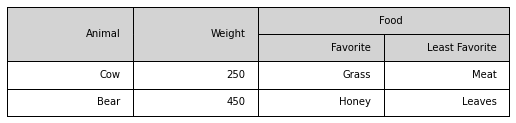

In [95]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame()
df['Animal'] = ['Cow', 'Bear']
df['Weight'] = [250, 450]
df['Favorite'] = ['Grass', 'Honey']
df['Least Favorite'] = ['Meat', 'Leaves']

fig = plt.figure(figsize=(9,2))
ax=fig.gca()
ax.axis('off')
r,c = df.shape

# ensure consistent background color
ax.table(cellColours=[['lightgray']] + [['none']], bbox=[0,0,1,1])

# plot the real table
table = ax.table(cellText=np.vstack([['', '', 'Food', ''], df.columns, df.values]), 
                 cellColours=[['none']*c]*(2 + r), bbox=[0, 0, 1, 1])

# need to draw here so the text positions are calculated
fig.canvas.draw()

# do the 3 cell merges needed
mergecells(table, (1,0), (0,0)) # Animal
mergecells(table, (1,1), (0,1)) # Weight
mergecells(table, (0,2), (0,3)) # Food

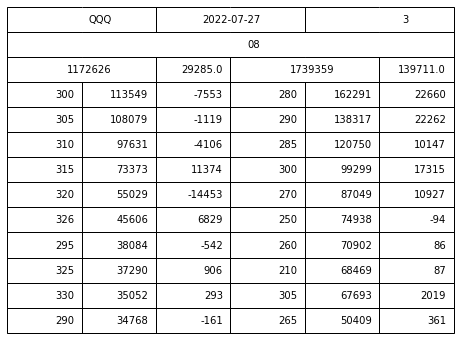

In [224]:
ticker = "QQQ"
fig = plt.figure(figsize=(8,6))
ax=fig.gca()
ax.axis('off')
test_call = update_call2.reset_index()['strike,open_interest,diff'.split(',')].head(10)
test_put = update_put2.reset_index()['strike,open_interest,diff'.split(',')].head(10)
test_df = pd.concat([test_call,test_put], axis=1)
r,c = test_df.shape

# ensure consistent background color
# ax.table(cellColours=[['lightgray']] + [['none']], bbox=[0,0,1,1])

# str(update_call2.ttm.unique()[0])[2:4]
# plot the real table
table = ax.table(cellText=np.vstack([[ticker, '', update_date.strftime("%Y-%m-%d"),'', str(update_date.isocalendar()[-1]), ''],
                                     [str(update_call2.ttm.unique()[0])[2:4], '', '', '', '', ''], 
                                     [update_call2.open_interest.sum(), '', update_call2['diff'].sum(),
                                     update_put2.open_interest.sum(), '', update_put2['diff'].sum()],
                                     test_df.astype(int).values]), 
                 cellColours=[['none']*c]*(3 + r), bbox=[0, 0, 1, 1])

# need to draw here so the text positions are calculated
fig.canvas.draw()

# do the 3 cell merges needed
mergecells2(table, [(0,0), (0,1)])
mergecells2(table, [(0,2), (0,3)])
mergecells2(table, [(0,4), (0,5)])

mergecells2(table, [(1,x) for x in range(c)])

mergecells2(table, [(2,0), (2,1)])
mergecells2(table, [(2,3), (2,4)])

In [252]:
from matplotlib.font_manager import fontManager, FontProperties
ChineseFont = FontProperties([f.name for f in fontManager.ttflist if 'JhengHei' in f.name or 'Heiti' in f.name][0]) #  or 'Arial' in f.name

In [260]:
def CreateTable(ticker, call_df, put_df, update_date):

    output_ = os.path.join(output_path, str(update_date.year), str(update_date.month).zfill(2), str(update_date.day).zfill(2))
    if not os.path.isdir(output_):
        os.makedirs(output_)
    fig = plt.figure(figsize=(7,6))
    ax=fig.gca()
    ax.axis('off')
    sub_call = call_df.reset_index()['strike,open_interest,diff'.split(',')].head(10)
    sub_put = put_df.reset_index()['strike,open_interest,diff'.split(',')].head(10)
    sub_df = pd.concat([sub_call,sub_put], axis=1)
    r,c = sub_df.shape

    # ensure consistent background color
    # ax.table(cellColours=[['lightgray']] + [['none']], bbox=[0,0,1,1])

    # str(update_call2.ttm.unique()[0])[2:4]
    # plot the real table
    table = ax.table(cellText=np.vstack([[ticker, '', update_date.strftime("%Y-%m-%d"),'', str(update_date.isocalendar()[-1]), ''],
                                         [str(call_df.ttm.unique()[0])[2:4], '', '', '', '', ''], 
                                         [call_df.open_interest.sum(), '', call_df['diff'].sum(),
                                         put_df.open_interest.sum(), '', put_df['diff'].sum()],
                                         sub_df.astype(int).values]), 
                     cellColours=[['none']*c]*(3 + r), bbox=[0, 0, 1, 1])
    table_props = table.properties()
    table_cells = table_props['children']
    for i, cell in enumerate(table_cells):
#             if not i:
#                 help(cell.set_text_props)
        cell.set_height(0.03)
        cell.set_text_props(fontproperties=ChineseFont, fontsize=12)
        text = cell.get_text().get_text()
        try:
            if int(text) < 0:
                cell.set_text_props(fontproperties=ChineseFont, fontsize=12, color='red')
        except:
            pass            
                
    # need to draw here so the text positions are calculated
    fig.canvas.draw()

    # do the 3 cell merges needed
    mergecells2(table, [(0,0), (0,1)])
    mergecells2(table, [(0,2), (0,3)])
    mergecells2(table, [(0,4), (0,5)])

    mergecells2(table, [(1,x) for x in range(c)])

    mergecells2(table, [(2,0), (2,1)])
    mergecells2(table, [(2,3), (2,4)])
    
    plt.savefig(os.path.join(output_, f'{ticker} Option OI Diff.jpeg'))
    plt.show(block=False)

def changeNumToChi(weekday):
    change_dict = {
        1:"週一",
        2:"週二",
        3:"週三",
        4:"週四",
        5:"週五",
    }
    return change_dict[weekday]

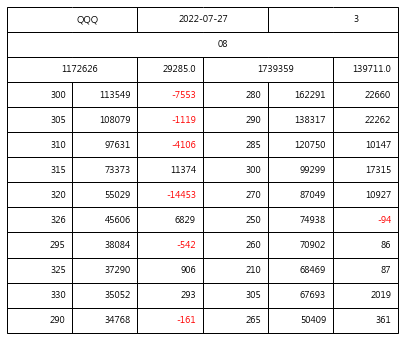

In [261]:
CreateTable('QQQ', update_call2, update_put2, update_date)

# Main

In [210]:
for ticker in 'QQQ,TQQQ,ARKK,SMH'.split(','): # used to follow NASDAQ
    GetOptionOI(ticker)
    break

for ticker in 'SPY,IWM'.split(','): # used to follow SPY
    GetOptionOI(ticker)
    
for ticker in 'TSLA,BITO,COIN'.split(','): # used to follow TLSA
    GetOptionOI(ticker)
    
for ticker in 'TSM,ASX,SIMO,HIMX,UMC,CHT,IMOS,GRMN'.split(','): # used to follow Taiwan Stock ADR # HNHPF,GIGM,LEDS,APWC,
    try:
        GetOptionOI(ticker)    
    except:
        print(ticker, "Failed")

for ticker in 'BABA,JD,BIDU,FXI'.split(','): # used to follow BABA
    try:
        GetOptionOI(ticker)    
    except:
        print(ticker, "Failed")

for ticker in 'GLD,GDX,SLV'.split(','): # used to follow XAUUSD 黃金現貨
    try:
        GetOptionOI(ticker)    
    except:
        print(ticker, "Failed")

for ticker in 'VIX'.split(','): # used to follow VIX
    try:
        GetOptionOI(ticker)    
    except:
        print(ticker, "Failed")

====== 2022-07-27 15:59:59 ======
====== 2022-07-27 16:00:00 ======
====== 2022-07-27 15:59:59 ======
====== 2022-07-27 15:59:59 ======
====== 2022-07-27 15:59:59 ======
====== 2022-07-27 15:59:59 ======
====== 2022-07-27 15:59:59 ======
====== 2022-07-27 15:59:59 ======
====== 2022-07-27 15:59:59 ======
====== 2022-07-27 15:59:59 ======
====== 2022-07-27 15:59:59 ======
====== 2022-07-27 15:59:50 ======
====== 2022-07-27 15:59:52 ======
====== 2022-07-27 15:59:59 ======
====== 2022-07-27 15:59:59 ======
====== 2022-07-27 15:59:59 ======
====== 2022-07-27 15:59:59 ======
====== 2022-07-27 15:59:59 ======
====== 2022-07-27 15:59:59 ======
====== 2022-07-27 15:59:59 ======
====== 2022-07-27 15:59:59 ======
====== 2022-07-28 07:33:01 ======
